In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from google.colab import files
import time
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from matplotlib.lines import Line2D



Saving data.csv to data.csv


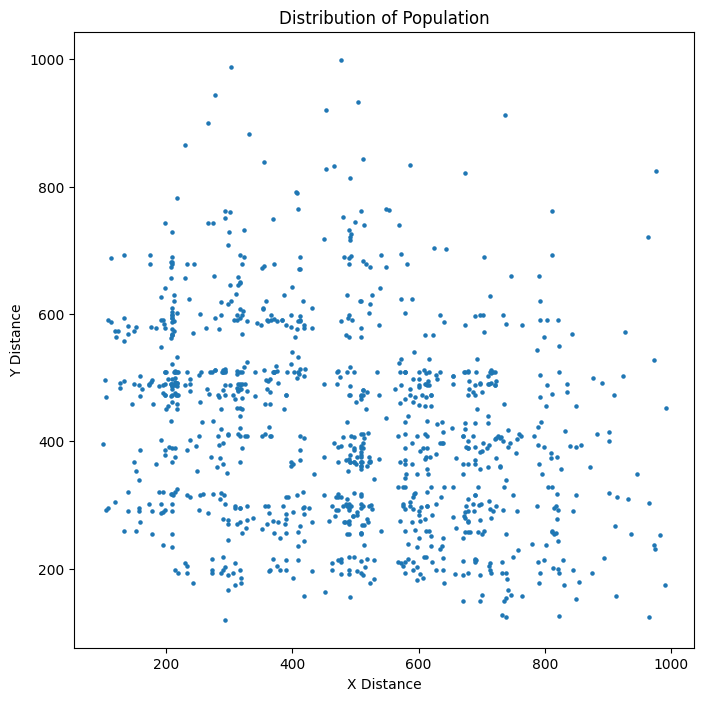

Total data points: 1014


In [3]:

uploaded = files.upload()
data = pd.read_csv('data.csv')
plt.figure(figsize=(8, 8))
plt.scatter(data['x'], data['y'], s=5)
plt.title('Distribution of Population')
plt.xlabel('X Distance')
plt.ylabel('Y Distance')
plt.show()

total_data_points = len(data)
print(f"Total data points: {total_data_points}")


In [37]:

max_cluster_size = 100
n_clusters = int(np.ceil(len(data) / max_cluster_size))
print(f'Initial number of clusters: {n_clusters}')
cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
start_time_initial = time.time()
cl = cluster.fit_predict(data[['x', 'y']])
end_time_initial = time.time()
initial_clustering_time = end_time_initial - start_time_initial
print(f"Time taken for initial clustering: {initial_clustering_time:.2f} seconds")

print(f'Clusters exceeding the maximum cluster size of {max_cluster_size} data points after initial clustering:')
for label in set(cl):
    if sum(cl == label) > max_cluster_size:
        print(f"Cluster {label} has {sum(cl == label)} data points and exceeds the maximum size.")


Initial number of clusters: 11
Time taken for initial clustering: 0.05 seconds
Clusters exceeding the maximum cluster size of 100 data points after initial clustering:
Cluster 0 has 161 data points and exceeds the maximum size.
Cluster 4 has 127 data points and exceeds the maximum size.
Cluster 6 has 104 data points and exceeds the maximum size.
Cluster 7 has 104 data points and exceeds the maximum size.
Cluster 9 has 102 data points and exceeds the maximum size.


In [23]:

def enforce_max_cluster_size(data, labels, max_size):
    unique_labels = set(labels)
    new_labels = labels.copy()
    next_label = max(labels) + 1

    def split_large_cluster(cluster_data, cluster_label, next_label, original_indices=None):
        if len(cluster_data) > max_size:
            sub_cluster = AgglomerativeClustering(n_clusters=2, linkage='ward')
            sub_labels = sub_cluster.fit_predict(cluster_data)
            if original_indices is None:
                original_indices = np.where(labels == cluster_label)[0]
            for sub_label in set(sub_labels):
                sub_cluster_data = cluster_data[sub_labels == sub_label]
                if len(sub_cluster_data) > max_size:
                    next_label = split_large_cluster(sub_cluster_data, next_label, next_label + 1, original_indices[sub_labels == sub_label])
                else:
                    new_labels[original_indices[sub_labels == sub_label]] = next_label
                    next_label += 1
        return next_label

    for label in unique_labels:
        if sum(labels == label) > max_size:
            cluster_data = data[labels == label]
            next_label = split_large_cluster(cluster_data, label, next_label)
    return new_labels




In [24]:
def calculate_centroids(data, labels):
    unique_labels = set(labels)
    centroids = []
    for label in unique_labels:
        points_in_cluster = data[labels == label]
        centroid = np.mean(points_in_cluster, axis=0)
        centroids.append((label, centroid))
    return centroids



In [25]:
def buffered_hull(points, buffer_distance=0.05):
    if len(points) < 3:
        return Polygon(points).buffer(buffer_distance)
    hull = ConvexHull(points)
    poly_points = points[hull.vertices]
    polygon = Polygon(poly_points)
    return polygon.buffer(buffer_distance)

In [29]:

start_time_enforce = time.time()
cl = enforce_max_cluster_size(data[['x', 'y']].values, cl, max_cluster_size)
end_time_enforce = time.time()
enforce_max_cluster_size_time = end_time_enforce - start_time_enforce
total_time = initial_clustering_time + enforce_max_cluster_size_time
print(f"Total time taken for clustering: {total_time:.2f} seconds")


unique_labels = sorted(set(cl))
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
cl = np.array([label_mapping[label] for label in cl])
centroids = calculate_centroids(data[['x', 'y']].values, cl)


Total time taken for clustering: 0.04 seconds


<ipython-input-30-0bc87eac8511>:19: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centroid[0], centroid[1], c='black', s=100, marker='x', edgecolors='w', zorder=5)


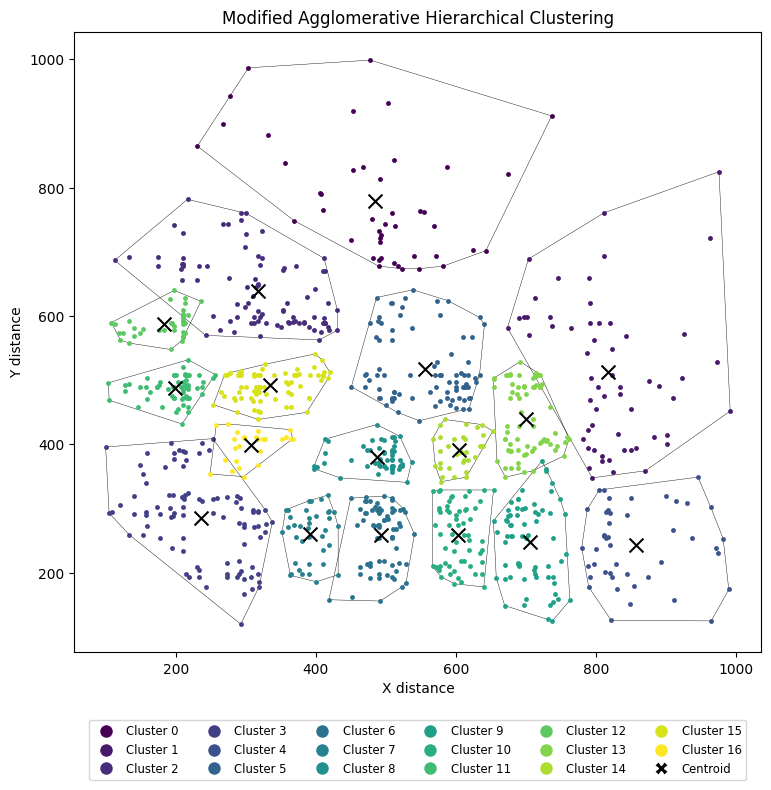

In [30]:

colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(8, 8))
legend_elements = []

for k, col in zip(unique_labels, colors):
    class_member_mask = (cl == k)
    xy = data[class_member_mask]
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10, label=f'Cluster {k}'))

    if len(xy) > 2:
        hull_polygon = buffered_hull(xy.values)
        if hull_polygon.is_valid:
            x, y = hull_polygon.exterior.xy
            plt.plot(x, y, 'k-', linewidth=0.3)

    plt.plot(xy['x'], xy['y'], '.', markerfacecolor=tuple(col), markersize=7, markeredgewidth=0)

for label, centroid in centroids:
    plt.scatter(centroid[0], centroid[1], c='black', s=100, marker='x', edgecolors='w', zorder=5)

legend_elements.append(Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10, label='Centroid'))


plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize='small', ncol=6)
plt.title('Modified Agglomerative Hierarchical Clustering')
plt.xlabel('X distance')
plt.ylabel('Y distance')
plt.tight_layout()
plt.show()


In [36]:

unique_labels = set(cl)
centroids = calculate_centroids(data[['x', 'y']].values, cl)

max_lines = 5

print_data = [f"Cluster {label}: {sum(cl == label)} data points" for label in unique_labels if label != -1]
formatted_output = [""] * max_lines
for i, line in enumerate(print_data):
    column_index = i // max_lines
    row_index = i % max_lines
    formatted_output[row_index] += f"{line:<30}"
print("\nDATA POINTS PER CLUSTER:")
for line in formatted_output:
    print(line)




DATA POINTS PER CLUSTER:
Cluster 0: 45 data points     Cluster 5: 85 data points     Cluster 10: 59 data points    Cluster 15: 76 data points    
Cluster 1: 59 data points     Cluster 6: 69 data points     Cluster 11: 66 data points    Cluster 16: 26 data points    
Cluster 2: 87 data points     Cluster 7: 38 data points     Cluster 12: 38 data points    
Cluster 3: 95 data points     Cluster 8: 54 data points     Cluster 13: 71 data points    
Cluster 4: 45 data points     Cluster 9: 68 data points     Cluster 14: 33 data points    


In [32]:
max_lines = 6
print_data = [f"Cluster {label}: {centroid}" for label, centroid in centroids]
formatted_output = [""] * max_lines
for i, line in enumerate(print_data):
    column_index = i // max_lines
    row_index = i % max_lines
    formatted_output[row_index] += f"{line:<45}"
print("\nCENTROIDS OF THE CLUSTERS:")
for line in formatted_output:
    print(line)



CENTROIDS OF THE CLUSTERS:
Cluster 0: [485.         778.82222222]       Cluster 6: [493.63768116 258.47826087]       Cluster 12: [183.84210526 587.18421053]      
Cluster 1: [817.83050847 512.38983051]       Cluster 7: [391.89473684 259.86842105]       Cluster 13: [700.84507042 440.12676056]      
Cluster 2: [317.3908046  639.18390805]       Cluster 8: [488.27777778 380.14814815]       Cluster 14: [605.18181818 391.06060606]      
Cluster 3: [236.43157895 285.46315789]       Cluster 9: [705.51470588 247.25      ]       Cluster 15: [334.38157895 492.59210526]      
Cluster 4: [857.11111111 242.77777778]       Cluster 10: [602.89830508 259.47457627]      Cluster 16: [307.53846154 398.42307692]      
Cluster 5: [555.65882353 518.07058824]       Cluster 11: [198.57575758 487.46969697]      
